In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers.experimental import RandomFourierFeatures

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Layer, Conv2D, Flatten, BatchNormalization, Concatenate, Multiply, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
data_file = "/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv"
data = pd.read_csv(data_file)

data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
all_paths = data['filepath'].values
all_labels = [label.strip('[\'').strip('\']')[0] for label in data['labels'].values]

paths, labels = [],[]
for i, path in enumerate(all_paths):
    if(all_labels[i] == 'N' or all_labels[i] == 'C'):
        paths.append(path)
        labels.append(all_labels[i])

In [4]:
# Task Name
task_name = "Cataract Diagnosis from Color Fundus Retinal Scan Images"

# Desired image dimensions
IMAGE_SIZE = (224, 224)
image_size = (224,224,3)

#directory_path
dir_path = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images"

#directory_path
dir_path = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K"

#Process Image Paths
img_paths = list(path.replace("../input/ocular-disease-recognition-odir5k/ODIR-5K", dir_path) for path in paths)

img_paths = list(path.replace('ODIR-5K/ODIR-5K/Training Images', 'preprocessed_images') for path in
    list(path.replace('ODIR-5K/ODIR-5K/Testing Images', 'preprocessed_images') for path in img_paths))

#List of categories
classes = ['N','D','G','C','A','H','M','O']

num_classes = len(classes)

#Decode Clsses to Integer Labels
processed_labels = to_categorical([1 if label=='C' else 0 for label in labels])

#Batch Size
BATCH_SIZE = 64

#Autotune
AUTOTUNE = tf.data.AUTOTUNE

#Epochs
EPOCHS = 50

In [5]:
# train test split
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(img_paths, processed_labels, test_size=0.2, random_state=42, stratify=processed_labels)

In [6]:
def process_images(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, label

# Prepare Training Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_imgs, train_labels))
train_ds = train_ds.map(process_images, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

# Prepare Testing Dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_imgs, test_labels))
test_ds = test_ds.map(process_images, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

2023-02-13 03:27:46.908963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 03:27:47.035683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 03:27:47.036587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 03:27:47.039665: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import Softmax
from keras.layers import Permute
from keras.layers import add, dot

from keras import backend as K


def GlobalContextBlock(ip, reduction_ratio=16, transform_activation='linear'):
    """
    Adds a Global Context attention block for self attention to the input tensor.
    Input tensor can be or rank 3 (temporal), 4 (spatial) or 5 (spatio-temporal).

    # Arguments:
        ip: input tensor
        intermediate_dim: The dimension of the intermediate representation. Can be
            `None` or a positive integer greater than 0. If `None`, computes the
            intermediate dimension as half of the input channel dimension.
        reduction_ratio: Reduces the input filters by this factor for the
            bottleneck block of the transform submodule. Node: the reduction
            ratio must be set such that it divides the input number of channels,
        transform_activation: activation function to apply to the output
            of the transform block. Can be any string activation function availahle
            to Keras.

    # Returns:
        a tensor of same shape as input
    """
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    ip_shape = K.int_shape(ip)

    # check rank and calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape

    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4

        if channel_dim == 1:
            batchsize, channels, dim1, dim2 = ip_shape
        else:
            batchsize, dim1, dim2, channels = ip_shape

    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5

        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape

    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')

    if rank > 3:
        flat_spatial_dim = -1 if K.image_data_format() == 'channels_first' else 1
    else:
        flat_spatial_dim = 1

    """ Context Modelling Block """
    # [B, ***, C] or [B, C, ***]
    input_flat = _spatial_flattenND(ip, rank)
    # [B, ..., C] or [B, C, ...]
    context = _convND(ip, rank, channels=1, kernel=1)
    # [B, ..., 1] or [B, 1, ...]
    context = _spatial_flattenND(context, rank)
    # [B, ***, 1] or [B, 1, ***]
    context = Softmax(axis=flat_spatial_dim)(context)

    # Compute context block outputs
    context = dot([input_flat, context], axes=flat_spatial_dim)
    # [B, C, 1]
    context = _spatial_expandND(context, rank)
    # [B, C, 1...] or [B, 1..., C]

    """ Transform block """
    # Transform bottleneck
    # [B, C // R, 1...] or [B, 1..., C // R]
    transform = _convND(context, rank, channels // reduction_ratio, kernel=1)
    # Group normalization acts as Layer Normalization when groups = 1
    #transform = GroupNormalization(groups=1, axis=channel_dim)(transform)
    transform = Activation('relu')(transform)

    # Transform output block
    # [B, C, 1...] or [B, 1..., C]
    transform = _convND(transform, rank, channels, kernel=1)
    transform = Activation(transform_activation)(transform)

    # apply context transform
    out = add([ip, transform])

    return out


def _convND(ip, rank, channels, kernel=1):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    if rank == 3:
        x = Conv1D(channels, kernel, padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    elif rank == 4:
        x = Conv2D(channels, (kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    else:
        x = Conv3D(channels, (kernel, kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)

    return x


def _spatial_flattenND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    ip_shape = K.int_shape(ip)
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = ip  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3]]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [ip_shape[1] * ip_shape[2], ip_shape[3]]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3] * ip_shape[4]]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [ip_shape[1] * ip_shape[2] * ip_shape[3], ip_shape[4]]

        x = Reshape(shape)(ip)

    return x


def _spatial_expandND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = Permute((2, 1))(ip)  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [-1, 1, 1]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [1, 1, -1]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [-1, 1, 1, 1]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [1, 1, 1, -1]

        x = Reshape(shape)(ip)

    return x

In [8]:
def SpatialAttention(fmaps):
    SA_A = tf.reduce_mean(fmaps,[0,3],keepdims=True) # Depth-wise Average Pooling
    Conv_A = Conv2D(1,3,activation='sigmoid',padding="same")(SA_A) # Apply Softmax based gated attention on Average-Spatial Map
    sa_fmaps = Multiply()([fmaps,Conv_A]) # multiply all feature maps with average spatial attention map
    return sa_fmaps

def ChannelAttention(fmaps):
    GAP = GlobalAveragePooling2D()(fmaps)
    FC1 = Dense(fmaps.shape[3]//8, activation='tanh')(GAP)
    FC2 = Dense(fmaps.shape[3], activation='sigmoid')(FC1)
    ca_fmaps = Multiply()([fmaps,FC2])
    return ca_fmaps

def build_model():
    
    inputs = Input(shape=image_size)
    base_model = EfficientNetB4(include_top=False, weights='imagenet',drop_connect_rate=0.5, input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable=False
    fmaps = base_model.output
    
    #Add Spatial Attention Layer
    sa_fmaps = SpatialAttention(fmaps)
    
    SA_GAP = GlobalAveragePooling2D()(sa_fmaps) # Squeeze average attention maps
    
    #Add Channel Attention Layer
    ca_fmaps = ChannelAttention(fmaps)
    
    CA_GAP = GlobalAveragePooling2D()(sa_fmaps) # Squeeze average attention maps
    
    GAP = GlobalAveragePooling2D()(fmaps) # Squeeze average maps
    
    gc_fmaps = GlobalContextBlock(fmaps)
    
    GC_GAP = GlobalAveragePooling2D()(gc_fmaps) # Squeeze average maps
    
    fused_fmaps = Concatenate()([GAP,SA_GAP,CA_GAP, GC_GAP])
    
    outputs = Dense(2, activation='softmax')(CA_GAP)
    model = Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])#Adam(learning_rate=1e-3)

    return model

# Create an object of the model
model = build_model()

71696384/71686520 [==============================] - 2s 0us/step


In [9]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

#print(model.summary())
#plot_model(model, show_shapes=True, to_file='model.png')

In [11]:
filepath = "/kaggle/working/fundus-image_cataract_classifier.h5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=25, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=25, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, rlrop, earlystopping]

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(train_ds,batch_size=BATCH_SIZE,
                 validation_data=test_ds,
                 epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 50 epochs...

Epoch 1/50
40/40 [==============================] - 8s 211ms/step - loss: 0.0821 - accuracy: 0.9747 - val_loss: 0.0736 - val_accuracy: 0.9732

Epoch 00001: val_accuracy improved from -inf to 0.97319, saving model to /kaggle/working/fundus-image_cataract_classifier.h5
Epoch 2/50
40/40 [==============================] - 10s 253ms/step - loss: 0.0831 - accuracy: 0.9743 - val_loss: 0.0727 - val_accuracy: 0.9732

Epoch 00002: val_accuracy did not improve from 0.97319
Epoch 3/50
40/40 [==============================] - 8s 208ms/step - loss: 0.0813 - accuracy: 0.9759 - val_loss: 0.0723 - val_accuracy: 0.9748

Epoch 00003: val_accuracy improved from 0.97319 to 0.97476, saving model to /kaggle/working/fundus-image_cataract_classifier.h5
Epoch 4/50
40/40 [==============================] - 8s 209ms/step - loss: 0.0802 - accuracy: 0.9731 - val_loss: 0.0727 - val_accuracy: 0.9732

Epoch 00004: val_accuracy did not improve from 0.97476
Epoch 5/50
40/40 [====

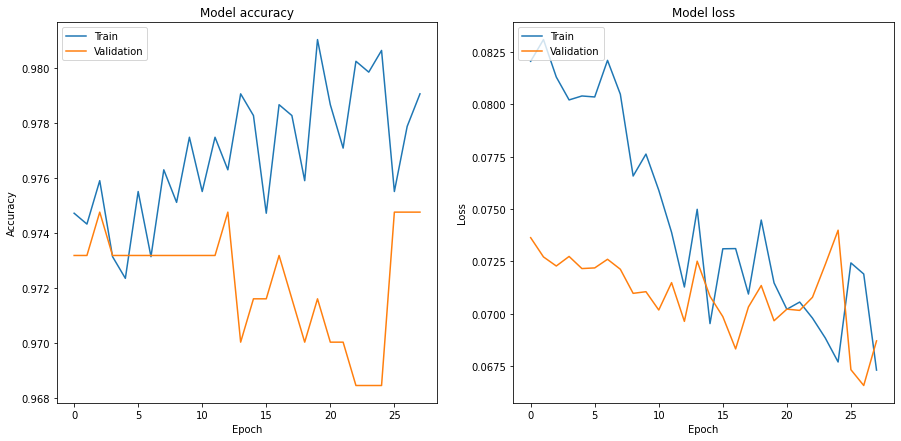

In [13]:
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

# Plot training & validation accuracy values
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Accuracy Plot')

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Loss Plot')

In [20]:
model.load_weights("/kaggle/working/fundus-image_cataract_classifier.h5")
model.evaluate(test_ds)

10/10 [==============================] - 2s 162ms/step - loss: 0.1882 - accuracy: 0.9290


[0.18817631900310516, 0.9290220737457275]

In [ ]:
#X_test = [imgs for imgs, _ in test_ds.unbatch()]
y_test = np.asarray([labels.numpy() for _, labels in test_ds.unbatch()])
Y_test = np.argmax(y_test, axis=-1)

y_score = model.predict(test_ds)
y_pred = np.argmax(y_score, axis=-1)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

acc = accuracy_score(Y_test,y_pred)
mpre = precision_score(Y_test,y_pred,average='macro')
mrecall = recall_score(Y_test,y_pred,average='macro')
mf1 = f1_score(Y_test,y_pred,average='macro')
kappa = cohen_kappa_score(Y_test,y_pred,weights='quadratic')
auc = roc_auc_score(Y_test, y_pred, average='macro', multi_class='ovr')


print("Accuracy: ",round(acc*100,2))
print("Macro Precision: ",round(mpre*100,2))
print("Macro Recall: ",round(mrecall*100,2))
print("Macro F1-Score: ",round(mf1*100,2))
print("Quadratic Kappa Score: ",round(kappa*100,2))
print("ROC AUC Score: ",round(auc*100,2))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred, digits=4, target_names = ['Normal', 'Cataract']))

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=True):
    
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    #thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy*100, misclass*100))
    plt.show()


# plot confusion matrix
cm = confusion_matrix(Y_test,y_pred)
targets = ['Normal', 'Cataract']
plot_confusion_matrix(cm, target_names = targets, title=task_name, cmap='Blues', normalize=True)

In [ ]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

num_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

colors = cycle(['red','blue','green','darkorange', 'purple', 'cyan', 'violet', 'peru', 'black', 'gold'])
classes = ['Normal', 'Cataract']
lw = 1.5

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(task_name)
plt.legend(loc="lower right")
plt.show()